In [1]:
import matplotlib
# matplotlib.use("TkAgg")
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib.figure import Figure
%matplotlib auto
# import tkinter as tk
# from tkinter import ttk
import Tkinter
class Point:
    def __init__(self, coordinates,auxData=None):
        self.data=auxData
        self.coords = coordinates
        self.edge = None
        self.ear = False
        self.next = None
        self.prev = None
        self.color= -1
    def ___str___(self):
        return str(self.ID)
    def __getitem__(self,key):
        return self.coords[key]
    def scale(self, k1, k2):
        self.coords = list(self.coords)
        self.coords[0] = int(self.coords[0] * k1)
        self.coords[1] = int(self.coords[1] * k2)
        self.coords = tuple(self.coords)
    def __hash__(self):
        return hash(id(self))
    def getData(self):
        return self.data
    def setData(self, auxData):
        self.data = auxData
    def getCoords(self):
        return Point(self.coords)
    def setCoords(self):
        self.coords = coordinates
    def getOutgoingEdges(self):
        visited = set()
        out = []
        here = self.edge
        while here and here not in visited:
            out.append(here)
            visited.add(here)
            temp = here.getTwin()
            if temp:
                here = temp.getNext()
            else:
                here = None
        return out
    def getIncidentEdge(self):
        return self.edge
    def setIncidentEdge(self, edge):
        self.edge = edge
    def __repr__(self):
        return 'DCEL.Point with coordnates (' + str(self.coords[0])+','+str(self.coords[1])+')'

class Edge:
    def __init__(self, auxData=None):
        self.data = auxData
        self.twin = None
        self.origin = None
        self.face = None
        self.next = None
        self.prev = None
    def __hash__(self):
        return hash(id(self))
    def getTwin(self):
        return self.twin
    def setTwin(self, twin):
        self.twin = twin
    def getData(self):
        return self.data
    def setData(self, auxData):
        self.data = auxData
    def getNext(self):
        return self.next
    def setNext(self, edge):
        self.next = edge
    def getOrigin(self):
        return self.origin
    def setOrigin(self, v):
        self.origin = v
    def getPrev(self):
        return self.prev
    def setPrev(self, edge):
        self.prev = edge
    def getDest(self):
        return self.twin.origin
    def getFace(self):
        return self.face
    def getFaceBoundary(self):
        visited = set()
        bound = []
        here = self
        while here and here not in visited:
            bound.append(here)
            visited.add(here)
            here = here.getNext()
        return bound
    def setFace(self, face):
        self.face = face
    def clone(self):
        c = Edge()
        c.data,c.twin,c.origin,c.face,c.next,c.prev = self.data,self.twin,self.origin,self.face,self.next,self.prev
    def __repr__(self):
        return 'DCEL.Edge from Origin: DCEL.Point with coordinates (' + str(self.getOrigin().coords[0])+','+str(self.getOrigin().coords[1])+')' + '\nDestination: DCEL.Point with coordinates (' + str(self.getDest().coords[0])+','+str(self.getDest().coords[1])+')'

class Face:
    def __init__(self, auxData=None):
        self.data = auxData
        self.outer = None
        self.inner = set()
        self.isolated = set()
    def __hash__(self):
        return hash(id(self))
    def getOuterComponent(self):
        return self.outer
    def setOuterComponent(self, edge):
        self.outer = edge
    def getData(self):
        return self.data
    def setData(self, auxData):
        self.data = auxData
    def getOuterBoundary(self):
        if self.outer:
            return self.outer.getFaceBoundary()
        else:
            return []
    def getOuterBoundaryCoords(self):
        original_pts = self.getOuterBoundary()
        return [x.origin.coords for x in original_pts]
    def getInnerComponents(self):
        return list(self.inner)
    def addInnerComponent(self, edge):
        self.inner.add(edge)
    def removeInnerComponent(self, edge):
        self.inner.discard(edge)
    def removeIsolatedVertex(self,Point):
        self.isolated.discard(Point)
    def getIsolatedVertices(self):
        return list(self.isolated)
    def addIsolatedVertex(self,Point):
        self.isolated.add(Point)

class DCEL:
    def __init__(self):
        self.exterior = Face()
    def getExteriorFace(self):
        return self.exterior
    def getFaces(self):
        result = []
        known = set()
        temp = []
        temp.append(self.exterior)
        known.add(self.exterior)
        while temp:
            f = temp.pop(0)
            result.append(f)
            for e in f.getOuterBoundary():
                nb = e.getTwin().getFace()
                if nb and nb not in known:
                    known.add(nb)
                    temp.append(nb)
            for inner in f.getInnerComponents():
                for e in inner.getFaceBoundary():
                    nb = e.getTwin().getFace()
                    if nb and nb not in known:
                        known.add(nb)
                        temp.append(nb)
        return result

    def getEdges(self):
        edges = set()
        for f in self.getFaces():
            edges.update(f.getOuterBoundary())
            for inner in f.getInnerComponents():
                edges.update(inner.getFaceBoundary())
        return edges

    def getVertices(self):
        verts = set()
        for f in self.getFaces():
            verts.update(f.getIsolatedVertices())
            verts.update([e.getOrigin() for e in f.getOuterBoundary()])
            for inner in f.getInnerComponents():
                verts.update([e.getOrigin() for e in inner.getFaceBoundary()])
        return verts
    

def buildSimplePolygon(points):
    d = DCEL()
    if points:
        exterior = d.getExteriorFace()
        interior = Face()
        verts = []
        for p in points:
            verts.append(Point(p))
        innerEdges = []
        outerEdges = []
        for i in range(len(verts)):
            e = Edge()
            e.setOrigin(verts[i])
            verts[i].setIncidentEdge(e)
            e.setFace(interior)
            t = Edge()
            t.setOrigin(verts[(i+1)%len(verts)])
            t.setFace(exterior)
            t.setTwin(e)
            e.setTwin(t)
            innerEdges.append(e)
            outerEdges.append(t)

        for i in range(len(verts)):
            innerEdges[i].setNext(innerEdges[(i+1)%len(verts)])
            innerEdges[i].setPrev(innerEdges[i-1])
            outerEdges[i].setNext(outerEdges[i-1])
            outerEdges[i].setPrev(outerEdges[(i+1)%len(verts)])
        interior.setOuterComponent(innerEdges[0])
        exterior.addInnerComponent(outerEdges[0])   
    return d


class Triangulation:
    def __init__(self, head = None, size = 0):
        self.HEAD = head
        self.SIZE = size


class Colorizer(object):
    def __init__(self,d,listTriangle):
        #Initialize color to -1
        self.colors = {v.coords:-1 for v in d.getVertices()}
        
        #Creating Dual Graph
        self.vdual={i:listTriangle[i] for i in range(0,len(listTriangle))}
        self.edual={}
        for i in range(0,len(listTriangle)):
            j=i+1
            for j in range(0,len(listTriangle)):
                triangle_i = [x.coords for x in listTriangle[i]]
                triangle_j = [x.coords for x in listTriangle[j]]
                if len(list(set(triangle_i)&set(triangle_j))) > 1:
                    if i in self.edual and j not in self.edual[i] and i is not j:
                        self.edual[i].append(j)
                    elif i not in self.edual and i is not j:
                        self.edual[i]=[j]
                    if j in self.edual and i not in self.edual[j] and i is not j:
                        self.edual[j].append(i)
                    elif j not in self.edual and i is not j:
                        self.edual[j]=[i]
    
    def DFS(self,s):
        visited, stack = set(), [s]
        while stack:
            vertex = stack.pop()
            if vertex not in visited:
                colorsum = self.colors[self.vdual[vertex][0].coords]+self.colors[self.vdual[vertex][1].coords]+self.colors[self.vdual[vertex][2].coords]
                if DEBUG:
                    print "Changing Coloring of Triangle#:"+str(vertex)+"  from: ",self.colors[vdual[vertex][0].coords],self.colors[vdual[vertex][1].coords],self.colors[vdual[vertex][2].coords]
                if colorsum<3:
                    if self.colors[self.vdual[vertex][0].coords] is -1:
                        self.colors[self.vdual[vertex][0].coords] = 3-self.colors[self.vdual[vertex][1].coords]-self.colors[self.vdual[vertex][2].coords]
                    elif self.colors[self.vdual[vertex][1].coords] is -1:
                        self.colors[self.vdual[vertex][1].coords] = 3-self.colors[self.vdual[vertex][0].coords]-self.colors[self.vdual[vertex][2].coords]
                    elif self.colors[self.vdual[vertex][2].coords] is -1:
                        self.colors[self.vdual[vertex][2].coords] = 3-self.colors[self.vdual[vertex][1].coords]-self.colors[self.vdual[vertex][0].coords] 
                if DEBUG:
                    print "to: ",self.colors[self.vdual[vertex][0].coords],self.colors[self.vdual[vertex][1].coords],self.colors[self.vdual[vertex][2].coords]
                visited.add(vertex)
                stack.extend(set(self.edual[vertex]) - visited)
    
    def colorize(self):
        #key = first triangle to be 3-colored
        key = 0
        if DEBUG:
            print("############################# INITIAL COLORING OF ONE TRIANGLE ##################################")
            print ("Triangle #"+str(key)+" Vertex #0 colored to 0")
        self.colors[self.vdual[key][0].coords] = 0
        if DEBUG:
            print ("Triangle #"+str(key)+" Vertex #1 colored to 1")
        self.colors[self.vdual[key][1].coords] = 1
        if DEBUG:
            print ("Triangle #"+str(key)+" Vertex #2 colored to 2")
        self.colors[self.vdual[key][2].coords] = 2
        if DEBUG:
            print("############################# GOING TO COLOR REMAINING TRIANGLES ###############################")
        self.DFS(key)
        output,col = self.findMinColor()
        return output,col

    def findMinColor(self):
        rcount,gcount,bcount=0,0,0
        r,g,b=[],[],[]
        out= set()
        for t in self.vdual.values():
            for it in t:
                if it.coords not in out:
                    if self.colors[it.coords] is 0:
                        rcount+=1
                        r.append(it)
                    elif self.colors[it.coords] is 1:
                        gcount+=1
                        g.append(it)
                    elif self.colors[it.coords] is 2:
                        bcount+=1
                        b.append(it)
                    out.add(it.coords)
        if rcount is gcount and rcount is bcount:
            return r,rcount
        if rcount<=gcount and rcount<=bcount:
            return r,rcount
        if gcount<=rcount and gcount<=bcount:
            return g,gcount
        if bcount<=rcount and bcount<=gcount:
            return b,bcount

# divide polygon in two // insert diagonal
def insertDgnl(d, p1, p2):
    if DEBUG:
        print "Inserting diagonal: ",p1,p2
    pointlist1 = []
    pointlist2 = []
    original_pts = d.getFaces()[1].getOuterBoundaryCoords()
    if (p1 in original_pts and p2 in original_pts) and p1!=p2:
        tmp1 = min(original_pts.index(p1), original_pts.index(p2))
        tmp2 = max(original_pts.index(p1), original_pts.index(p2))
        pointlist1 = original_pts[tmp1:(tmp2+1)]
        pointlist2 = original_pts[tmp2:]+original_pts[:(tmp1+1)]
        d1 = buildSimplePolygon(pointlist1)
        d2 = buildSimplePolygon(pointlist2)
        return [d1,d2]
    return [d]

# divide polygon in many // insert list of diagonals
def insertDgnls(d, dgnls):
    ngons = [d]
    while dgnls != []:
        nxt = dgnls.pop(0)
        print "Current dgnl:",nxt
        ngons = [insertDgnl(x, nxt[0], nxt[1]) for x in ngons]
        ngons = [ngon for lngon in ngons for ngon in lngon]
        print len(ngons)
    return ngons

Using matplotlib backend: Qt5Agg


In [2]:
class trapEdge(object):
    def __init__(self,a,b,s,l,r):
        self.left = a
        self.right = b
        self.pivot = s
        self.le = l
        self.re = r

class point(object):
    def __init__(self, a, b):
        self.x = a
        self.y = b
        
def onSegment(p,q,r):
    if (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y)):
        return True
    return False
def orientation(p,q,r):
    val = (q.y - p.y) * (r.x - q.x) -(q.x - p.x) * (r.y - q.y)
    if (val == 0):
        return 0
    if(val>0):
        return 1
    return 2
def doIntersect(p1,q1,p2,q2):
    o1 = orientation(p1, q1, p2);
    o2 = orientation(p1, q1, q2);
    o3 = orientation(p2, q2, p1);
    o4 = orientation(p2, q2, q1);
    A,B,C,D = p1,q1,p2,q2
    a1 = B.y - A.y
    b1 = A.x - B.x
    c1 = a1*(A.x) + b1*(A.y)
    a2 = D.y - C.y
    b2 = C.x - D.x
    c2 = a2*(C.x)+ b2*(C.y)
    determinant = a1*b2 - a2*b1
    if(determinant == 0):
        return False
    if (o1 != o2 and o3 != o4):
        return True
    if (o1 == 0 and onSegment(p1, p2, q1)):
        return True
    if (o2 == 0 and onSegment(p1, q2, q1)):
        return True
    if (o3 == 0 and onSegment(p2, p1, q2)):
        return True
    if (o4 == 0 and onSegment(p2, q1, q2)):
        return True
    return False

def findIt(A,B,C,D):
    a1 = B.y - A.y
    b1 = A.x - B.x
    c1 = a1*(A.x) + b1*(A.y)
    a2 = D.y - C.y
    b2 = C.x - D.x
    c2 = a2*(C.x)+ b2*(C.y)
    determinant = a1*b2 - a2*b1
    x = (b2*c1 - b1*c2)/determinant
    y = (a1*c2 - a2*c1)/determinant
    return (x, y)

def findIntersections(lines, hlines):
    res = {}
    for hline in hlines:
        p1 = point(hline[0],hline[1])
        q1 = point(hline[2],hline[3])
        for line in lines:
            p2 = point(line[0][0],line[0][1])
            q2 = point(line[0][2],line[0][3])
            if(doIntersect(p1,q1,p2,q2)):
                res[findIt(p1,q1,p2,q2)] = line[1]
    return res

def getTrapEdges(d):
    N = len(d.getVertices())
    verts = [ list(d.getVertices())[i].coords for i in range(N) ]
    verts = zip(verts, [i for i in list(d.getVertices())])
    edges = [(verts[i][1].next.coords,verts[i][1].coords) for i in range(N) ]
    edges = zip(edges, [v[1].getOutgoingEdges()[0] for v in verts])
    verts.sort(key=lambda x: -x[0][0])
    lines = []
    temp = []
    for e in edges:
        temp = [e[0][0][0],e[0][0][1],e[0][1][0],e[0][1][1]],e[1]
        lines.append(temp)
    lines2 = []
    temp = []
    for v in verts:
        temp = verts[0][0][0],v[0][1],verts[-1][0][0],v[0][1]
        lines2.append(temp)
    res = findIntersections(lines,lines2)

    res = [[x,y,res[(x,y)]] for (x,y) in res]
    res.sort(key = lambda x: -x[1])
    ret = []
    
    for v in verts:
        templ = [(x[0],x[1],x[2]) for x in res if (x[0]<v[0][0] and x[1]==v[0][1])]
        tempr = [(x[0],x[1],x[2]) for x in res if (x[0]>v[0][0] and x[1]==v[0][1])]
        templ.sort(key = lambda x: x[0])
        tempr.sort(key = lambda x: x[0])
        if( len(templ)%2==0 and len(tempr)%2==0 ):
            if v[1].getOutgoingEdges()[0].getTwin().origin.coords[1] < v[1].coords[1] :
                tr = trapEdge(v[0],v[0],v[1],v[1].getOutgoingEdges()[0],v[1].getOutgoingEdges()[1].getTwin())
            else:
                tr = trapEdge(v[0],v[0],v[1],v[1].getOutgoingEdges()[1],v[1].getOutgoingEdges()[0])
#                 tr = trapEdge(v[0],v[0],v[1],None,None)
            ret.append(tr)
        if( len(templ)%2==1 and len(tempr)%2==1 ):
            tr = trapEdge(templ[-1][:2],tempr[0][:2],v[1],templ[-1][2],tempr[0][2])
            ret.append(tr)
        if( len(templ)%2==0 and len(tempr)%2==1 ):
            tr = trapEdge(v[0],tempr[0][:2],v[1],v[1].getOutgoingEdges()[0], tempr[0][2])
            ret.append(tr)
        if( len(templ)%2==1 and len(tempr)%2==0 ):
            tr = trapEdge(templ[-1][:2],v[0],v[1],templ[-1][2],v[1].getOutgoingEdges()[1].getTwin())
            ret.append(tr)
    
    return ret

In [3]:
# returns list of diagonals for partioning

def monotonePartitioningDgnls(d):
    
    ret = getTrapEdges(d)
    ret = sorted(ret, key=lambda x:-x.pivot.coords[1])

    a = dict()
    b = dict()

    for x in ret:
        x.re = x.re.getTwin()
        if DEBUG:
            print "\n",x.left,x.right
            print "Pivot:",x.pivot.coords
            print "Ledge:",x.le.origin.coords,"-->",x.le.getTwin().origin.coords
            print "Redge:",x.re.origin.coords,"-->",x.re.getTwin().origin.coords


        if x.pivot.coords[1] > x.re.getTwin().origin.coords[1]:
            a[x.pivot] = (x.le,x.re)
            if x.le in b:
                b[x.le].append(x.pivot)
            else:
                b[x.le] = [x.pivot]

            if x.re in b:
                b[x.re].append(x.pivot)
            else:
                b[x.re] = [x.pivot]
                
#             if (x.pivot.getOutgoingEdges()[0].getTwin().origin.coords[1] < x.pivot.coords[1] and
#                 x.pivot.getOutgoingEdges()[1].getTwin().origin.coords[1] < x.pivot.coords[1] and
#                 x.pivot != x.le.origin ): # split vertex
                
#                 lc = x.pivot.getOutgoingEdges()[1]
#                 rc = x.pivot.getOutgoingEdges()[0]
                
#                 a.append((x.le,lc))
#                 a.append((rc,x.re))
                
                
                
# #                 if lc in b:
# #                     b[lc].append(x.pivot)
# #                 else:
# #                     b[lc] = [x.pivot]
                    
# #                 if rc in b:
# #                     b[rc].append(x.pivot)
# #                 else:
# #                     b[rc] = [x.pivot]
                
            

    for e in b:
        b[e].append(e.getTwin().origin)

    if DEBUG:
        print "\n### a"    
        for (i,x) in enumerate(a):
            print
            print i,x.coords
            for e in a[x]:
                print e.origin.coords, e.getTwin().origin.coords

        print "\n### b"
        for (i,x) in enumerate(b):
            print
            print i,x.origin.coords, x.getTwin().origin.coords
            print b[x]

    dgnls = []
    # pt = list(a.keys())[1]

    # print "]]]]",pt.coords
    # print a[pt]
    # print [x.coords for x in b[a[pt][0]] ],b[a[pt][0]].index(pt)
    # print [x.coords for x in b[a[pt][1]] ],b[a[pt][1]].index(pt),"[[[[["

    for pt in sorted(a, key=lambda x:-x.coords[1]):
        if DEBUG:
            print "\n]]]]",pt.coords
            print a[pt][0].origin.coords, a[pt][0].getTwin().origin.coords,
            print len(b[a[pt][0]]),[x.coords for x in b[a[pt][0]] ],b[a[pt][0]].index(pt)
            print a[pt][1].origin.coords, a[pt][1].getTwin().origin.coords,
            print len(b[a[pt][1]]),[x.coords for x in b[a[pt][1]] ],b[a[pt][1]].index(pt),"[[[[["

#         if not a[pt][0].origin == a[pt][1].origin:
#             print "in"
        if pt in ( a[pt][0].origin, a[pt][0].getTwin().origin ):
            dgnls.append((pt, b[a[pt][1]][b[a[pt][1]].index(pt)+1] ))
        elif pt in ( a[pt][1].origin, a[pt][1].getTwin().origin ):
            dgnls.append((pt, b[a[pt][0]][b[a[pt][0]].index(pt)+1] ))
        else:
            dgnls.append((pt,
                          min( b[a[pt][0]][b[a[pt][0]].index(pt)+1], 
                               b[a[pt][1]][b[a[pt][1]].index(pt)+1], 
                               key=lambda x:x.coords[1]
                             )
                         ))
        if DEBUG:
            print "Dgnls:",[(x[0].coords,x[1].coords) for x in dgnls]

    if DEBUG:
        print "ppp",[(x.origin,x.getTwin().origin) for x in d.getEdges()]
        for ww in dgnls:
            print ww in [(x.origin,x.getTwin().origin) for x in d.getEdges()]
    dgnls = list(set(dgnls)-set([(x.origin,x.getTwin().origin) for x in d.getEdges()]))
    return dgnls

In [4]:
# triangulate Monotone Polygon // get list of diagonals
# !!!!!! sadly not yet implemented the function to check reflex angle

def Orientation(p,q,r):
    p=p.coords
    q=q.coords
    r=r.coords
    val = ( q[1] - p[1] )*( r[0] - q[0] ) - ( q[0] - p[0] )* ( r[1] - q[1] )
    return -val

def reflex(p,q,r,chain = 'l'):
    if(chain == 'r'):
        if Orientation(p,q,r)>=0:
            return True
        else:
            return False
    elif(chain == 'l'):
        if Orientation(p,q,r)>0:
            return False
        else:
            return True
    

def triangulateMonotonePolygon(d):
    pts = [x.origin for x in d.getFaces()[1].getOuterBoundary()]
    if DEBUG:
        print "Polygon Boundary:",[x.coords for x in pts]
    min_index = min(enumerate(pts), key=lambda x:x[1].coords[1])[0]
    max_index = max(enumerate(pts), key=lambda x:x[1].coords[1])[0]
    tmp1 = min(min_index,max_index)
    tmp2 = max(min_index,max_index)
    chain1 = pts[tmp1:(tmp2+1)] 
    chain2 = pts[tmp2:]+pts[:(tmp1+1)] 
    
    if(min(chain1, key=lambda x:x.coords[0]).coords[0] >min(chain2, key=lambda x:x.coords[0]).coords[0]):    # ensuring chain1 is left chain
        if DEBUG:
            print "Monotone chains swapped"
        tmp = list(chain1)
        chain1 = chain2
        chain2 = tmp
    if DEBUG:
        print "Left Chain     : ",[x.coords for x in chain1]
        print "Right Chain    : ",[x.coords for x in chain2]
    pts = sorted(pts, key = lambda x:-x.coords[1])
    if DEBUG:
        print "\nSorted pts     : ",[x.coords for x in pts]
        print
    
    queue = []
    diagonals = []
    
    queue.append(pts[0])
    queue.append(pts[1])
    
    i = 2
    while i < (len(pts)-1):
        if DEBUG:
            print "\ni =",i,";",pts[i].coords
        #process(pts[i])
        tmp1 = queue[-1] in chain1
        tmp2 = pts[i] in chain1 
        if (tmp1 and not tmp2) or (tmp2 and not tmp1):
            for qpt in queue[1:]:
                diagonals.append((pts[i], qpt))
                if DEBUG:
                    print "Case: a;  \nDiagonals:", [(x[0].coords,x[1].coords) for x in diagonals]
            queue = [queue[-1],pts[i]]
            if DEBUG:
                print "Queue: ",[x.coords for x in queue]
        else:
            if DEBUG:
                print "||||||",queue[-2],queue[-1],pts[i],"chain =", ('l' if tmp1 else 'r'),"|||||"
                print reflex(queue[-2],queue[-1],pts[i],chain = ('l' if tmp1 else 'r') )
                print Orientation(queue[-2],queue[-1],pts[i] )
            if reflex(queue[-2],queue[-1],pts[i],chain = ('l' if tmp1 else 'r') ):
                queue.append(pts[i])
                if DEBUG:
                    print "Case: b;  \nDiagonals:",# reflex
                    print [(x[0].coords,x[1].coords) for x in diagonals]
                    print "Queue: ",[x.coords for x in queue]
            else:
                diagonals.append((pts[i], queue[-2]))
                if DEBUG:
                    print "Case: c;  \nDiagonals:", # convex
                    print [(x[0].coords,x[1].coords) for x in diagonals]
                    print "Queue: ",[x.coords for x in queue]
                queue.pop(-1)
                if len(queue) == 1:
                    queue.append(pts[i])
                else:
                    i-=1
        i+=1
    
    if len(queue)>2:
        for qpt in queue[1:-1]:
                diagonals.append((pts[i], qpt))
                if DEBUG:
                    print "Case: a;  \nDiagonals:", [(x[0].coords,x[1].coords) for x in diagonals]
    
    if DEBUG:
        print "Queue: ",[x.coords for x in queue]
    return diagonals
            
        
# triangulateMonotonePolygon(d)
# listOfTriangles = insertDgnls(d,triangulateMonotonePolygon(d))

In [ ]:
p=[]
N= int(raw_input())
lines=[raw_input().strip() for i in range(0,N)]
p=[(float(lines[i].split()[0]),int(lines[i].split()[1])) for i in range(0,len(lines))]
d = buildSimplePolygon(p)
print("################################ DCEL POLYGON FORMED ###################################")
map_points ={x.coords:x for x in d.getVertices()}
for i in range(1,len(p)-1):
    map_points[p[i]].next = map_points[p[i+1]]
    map_points[p[i+1]].prev = map_points[p[i]]
map_points[p[0]].prev = map_points[p[-1]]
map_points[p[0]].next = map_points[p[1]]
map_points[p[1]].prev = map_points[p[0]]
map_points[p[-1]].next = map_points[p[0]]
# 10
# 2 1
# 4 3
# 6 0
# 7 4
# 8 2
# 9 9
# 7 6
# 5 7
# 5 5
# 1 8


In [7]:
DEBUG = True
ret = getTrapEdges(d)
ret = sorted(ret, key=lambda x:-x.pivot.coords[1])
if DEBUG:
    for x in ret:
        print x.pivot

diagnls = monotonePartitioningDgnls(d)
listOfMonos = insertDgnls(d,[(x[0].coords,x[1].coords) for x in diagnls])

listOfTriangles = []
for mono in listOfMonos:
    diagnls = triangulateMonotonePolygon(mono)
    vv = [(x[0].coords,x[1].coords) for x in diagnls]
    listOfTriangles += insertDgnls(mono,vv)
listOfTriangles = [[t.getFaces()[1].getOuterBoundary()[0].origin,
                    t.getFaces()[1].getOuterBoundary()[1].origin,
                    t.getFaces()[1].getOuterBoundary()[2].origin
                   ] for t in listOfTriangles]


if DEBUG:
    print("################################# TRIANGULATED REGIONS ####################################")
s =[]
if DEBUG:
    for i,item in enumerate(listOfTriangles):
        print i,item
        print("Triangle #"+str(i))
        print(item[0])
        print(item[1])
        print(item[2])

s = [[x.coords for x in t] for t in listOfTriangles]
# print s

if DEBUG:
    print("################################ GRAPHICAL VIEW #####################################")
def drawTriangles(canvas, triangles):
    if len(triangles) > 0:
        for t in triangles:
            canvas.create_line(10*t[0].coords[0], 700 - 10*t[0].coords[1], 10*t[1].coords[0], 700 - 10*t[1].coords[1],width = 1.0, fill = 'red')
            canvas.create_line(10*t[0].coords[0], 700 - 10*t[0].coords[1], 10*t[2].coords[0], 700 - 10*t[2].coords[1],width = 1.0, fill = 'red')
            canvas.create_line(10*t[2].coords[0], 700 - 10*t[2].coords[1], 10*t[1].coords[0], 700 - 10*t[1].coords[1],width = 1.0, fill = 'red')

canvas_width = 1000
canvas_height = 800
master = Tkinter.Tk()
canvas = Tkinter.Canvas(master, width=canvas_width, height=canvas_height)
canvas.pack()
drawTriangles(canvas, listOfTriangles)
Tkinter.mainloop()


DEBUG = False
colorizer = Colorizer(d,listOfTriangles)
colorizer.colorize()

DCEL.Point with coordnates (54,83)
DCEL.Point with coordnates (-34,68)
DCEL.Point with coordnates (24,63)
DCEL.Point with coordnates (-57,56)
DCEL.Point with coordnates (10,36)
DCEL.Point with coordnates (-4,23)
DCEL.Point with coordnates (41,18)
DCEL.Point with coordnates (-70,12)
DCEL.Point with coordnates (-26,-13)
DCEL.Point with coordnates (15,-27)
DCEL.Point with coordnates (-55,-55)
DCEL.Point with coordnates (62,-67)
DCEL.Point with coordnates (-16,-77)
DCEL.Point with coordnates (68,-79)
DCEL.Point with coordnates (-18,-81)
DCEL.Point with coordnates (32,-86)

(54, 83) (54, 83)
Pivot: (54, 83)
Ledge: (54, 83) --> (41, 18)
Redge: (54, 83) --> (62, -67)

(-34, 68) (-34, 68)
Pivot: (-34, 68)
Ledge: (-34, 68) --> (-57, 56)
Redge: (-34, 68) --> (-4, 23)

(24, 63) (24, 63)
Pivot: (24, 63)
Ledge: (24, 63) --> (10, 36)
Redge: (24, 63) --> (41, 18)

(-57, 56) (-26, 56)
Pivot: (-57, 56)
Ledge: (-57, 56) --> (-26, -13)
Redge: (-34, 68) --> (-4, 23)

(10, 36) (34, 36)
Pivot: (10, 36)
Ledg

([DCEL.Point with coordnates (-4,23),
  DCEL.Point with coordnates (-55,-55),
  DCEL.Point with coordnates (41,18),
  DCEL.Point with coordnates (68,-79)],
 4)

In [5]:
n = 16

In [10]:
from numpy.random import randint
from numpy import lexsort,asarray,append
coords = randint(-90,90, size=(2,n))
x = coords[0] 
y = coords[1]
ind = lexsort((y,x))
coords = [(x[i],y[i]) for i in ind] 
x = asarray([c[0] for c in coords])
y = asarray([c[1] for c in coords])
pivot = coords[0]

y_diff_pivot = y-pivot[1]
x_diff_pivot = x-pivot[0]
tan = (y_diff_pivot[1:]+0.0)/x_diff_pivot[1:]

pairs = zip(tan,coords[1:])
pairs = sorted(pairs, key = lambda (x,y): x)

coords = asarray([pivot])
coords = append(coords, asarray( zip(*pairs)[-1] ), axis=0 )
coords = append(coords, asarray([pivot]), axis=0 )
p=[(c[1],c[0]) for c in coords][::-1][1:]
print len(p),p
d = buildSimplePolygon(p)

print("################################ DCEL POLYGON FORMED ###################################")
map_points ={x.coords:x for x in d.getVertices()}
for i in range(1,len(p)-1):
    map_points[p[i]].next = map_points[p[i+1]]
    map_points[p[i+1]].prev = map_points[p[i]]
map_points[p[0]].prev = map_points[p[-1]]
map_points[p[0]].next = map_points[p[1]]
map_points[p[1]].prev = map_points[p[0]]
map_points[p[-1]].next = map_points[p[0]]

16 [(63, -57), (86, -9), (82, 46), (71, 67), (48, 42), (37, 56), (47, -45), (-2, 74), (-30, 89), (14, 3), (44, -50), (-64, 73), (-67, 65), (8, -27), (-20, -60), (53, -65)]
################################ DCEL POLYGON FORMED ###################################


In [11]:
import matplotlib.pyplot as plt
import numpy as np
def newline(p, q):
    X = np.linspace(p[0], q[0],endpoint=True)
    Y = np.linspace(p[1],q[1],endpoint=True)
    return X,Y

def nowDraw(toDraw):
    for x in toDraw:
        plt.plot(x[0],x[1],x[2])
    plt.show()

toDraw = []
for e in d.getEdges():
    p1,q1 = list(e.origin.coords),list(e.getTwin().origin.coords)
    X,Y = newline(p1,q1)
    toDraw.append([X,Y,'r'])
#     plt.plot(x1, y1, x2, y2, marker = 'o')

In [12]:
nowDraw(toDraw)

In [22]:
DEBUG = True
ret = getTrapEdges(d)
for r in ret:
    X,Y = newline(r.left,r.right)
    toDraw.append([X,Y,'b'])
    toDraw.append([r.pivot.coords[0],r.pivot.coords[1],'go'])

In [37]:

nowDraw(toDraw)

In [25]:
DEBUG = False
diagnls = monotonePartitioningDgnls(d)
for dg in  diagnls:
    X,Y = newline(dg[0].coords,dg[1].coords)
    toDraw.append([X,Y,'g'])

In [26]:
diagnls

[(DCEL.Point with coordnates (-10,-61), DCEL.Point with coordnates (18,-85)),
 (DCEL.Point with coordnates (57,-42), DCEL.Point with coordnates (-10,-61)),
 (DCEL.Point with coordnates (-55,74), DCEL.Point with coordnates (14,58)),
 (DCEL.Point with coordnates (14,58), DCEL.Point with coordnates (-56,38)),
 (DCEL.Point with coordnates (-68,86), DCEL.Point with coordnates (-55,74)),
 (DCEL.Point with coordnates (-71,5), DCEL.Point with coordnates (-32,-18)),
 (DCEL.Point with coordnates (-32,-18), DCEL.Point with coordnates (42,-21))]

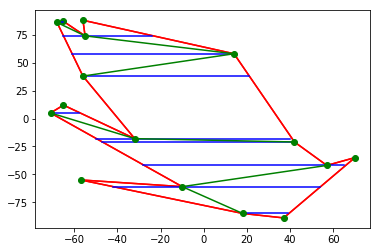

In [27]:
nowDraw(toDraw)

In [28]:
listOfMonos = insertDgnls(d,[(x[0].coords,x[1].coords) for x in diagnls])

Current dgnl: ((-10, -61), (18, -85))
2
Current dgnl: ((57, -42), (-10, -61))
3
Current dgnl: ((-55, 74), (14, 58))
4
Current dgnl: ((14, 58), (-56, 38))
5
Current dgnl: ((-68, 86), (-55, 74))
6
Current dgnl: ((-71, 5), (-32, -18))
7
Current dgnl: ((-32, -18), (42, -21))
8


In [29]:
toDraw = []
for m in listOfMonos:
    for e in m.getEdges():
        p1,q1 = list(e.origin.coords),list(e.getTwin().origin.coords)
        X,Y = newline(p1,q1)
        toDraw.append([X,Y,''])
        toDraw.append([e.origin.coords[0],e.origin.coords[1],'o'])

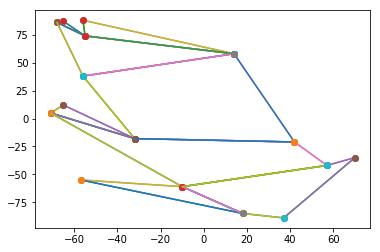

In [30]:
nowDraw(toDraw)

In [31]:
listOfTriangles = []
mono = listOfMonos[2]
diagnls = triangulateMonotonePolygon(mono)
vv = [(x[0].coords,x[1].coords) for x in diagnls]
listOfTriangles += insertDgnls(mono,vv)
print listOfTriangles

[<__main__.DCEL instance at 0x7f3226b2fb00>]


In [32]:
DEBUG = False
toDraw = []
listOfTriangles = []
tmp = -1
print len(listOfMonos)
for mono in listOfMonos:
    diagnls = triangulateMonotonePolygon(mono)
    vv = [(x[0].coords,x[1].coords) for x in diagnls]
    listOfTriangles += insertDgnls(mono,vv)
#     print listOfTriangles
    tmp+=len(diagnls)+1
print "\n",tmp
print len(listOfTriangles)
listOfTriangles = [[t.getFaces()[1].getOuterBoundary()[0].origin,
                    t.getFaces()[1].getOuterBoundary()[1].origin,
                    t.getFaces()[1].getOuterBoundary()[2].origin
                   ] for t in listOfTriangles]
# for i,t in enumerate(listOfTriangles):
#     print i,'[',t.getFaces()[1].getOuterBoundary()[0].origin.coords, \
#            t.getFaces()[1].getOuterBoundary()[1].origin.coords, \
#            t.getFaces()[1].getOuterBoundary()[2].origin.coords,           ']'

print len(listOfTriangles)
for t in listOfTriangles:
    p1,q1 = list(t[0].coords),list(t[1].coords)
    print p1,q1,list(t[2].coords)
    X,Y = newline(p1,q1)
    toDraw.append([X,Y,'r'])
    p1,q1 = list(t[1].coords),list(t[2].coords)
    X,Y = newline(p1,q1)
    toDraw.append([X,Y,'b'])
    p1,q1 = list(t[2].coords),list(t[0].coords)
    X,Y = newline(p1,q1)
    toDraw.append([X,Y,'g'])
    

8
Current dgnl: ((-32, -18), (14, 58))
2
Current dgnl: ((57, -42), (-32, -18))
2
Current dgnl: ((-10, -61), (-32, -18))
3
Current dgnl: ((-56, 38), (-55, 74))
2
Current dgnl: ((18, -85), (57, -42))
2
Current dgnl: ((18, -85), (70, -35))
3

13
14
14
[-10, -61] [-57, -55] [18, -85]
[14, 58] [-56, 88] [-55, 74]
[-32, -18] [-65, 12] [-71, 5]
[14, 58] [-56, 38] [-32, -18]
[-32, -18] [42, -21] [14, 58]
[-32, -18] [-71, 5] [-10, -61]
[-10, -61] [57, -42] [-32, -18]
[57, -42] [42, -21] [-32, -18]
[-55, 74] [-65, 87] [-68, 86]
[-56, 38] [14, 58] [-55, 74]
[-55, 74] [-68, 86] [-56, 38]
[18, -85] [37, -89] [70, -35]
[70, -35] [57, -42] [18, -85]
[57, -42] [-10, -61] [18, -85]


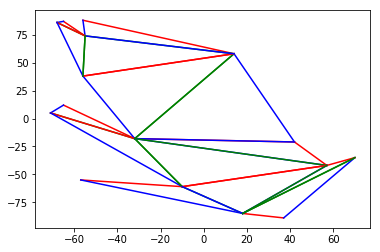

In [33]:
nowDraw(toDraw)

In [34]:
colorizer = Colorizer(d,listOfTriangles)
colorizer.colorize()

([DCEL.Point with coordnates (18,-85),
  DCEL.Point with coordnates (-55,74),
  DCEL.Point with coordnates (-32,-18)],
 3)